In [0]:
# -*- coding: utf-8 -*-

"""
NEURAL NETWORKS AND DEEP LEARNING

ICT FOR LIFE AND HEALTH - Department of Information Engineering
PHYSICS OF DATA - Department of Physics and Astronomy
COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY - Department of Psychology

A.A. 2019/20 (6 CFU)
Dr. Alberto Testolin, Dr. Federico Chiariotti

Author: Dr. Matteo Gadaleta

Lab. 02 - Linear regression with artificial neurons
 
"""

import os
import torch
import matplotlib.pyplot as plt
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
import numpy as np
import random


# IMPORTING

In [0]:


#%% Define paths

data_root_dir = '../datasets'

# Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., level=0):
        self.std = std
        self.mean = mean
        self.level = level
        
    def __call__(self, tensor):
        tensor = tensor + self.level*(torch.randn(tensor.size()) * self.std + self.mean) #adding noise
        tensor = (tensor-torch.min(tensor))/(torch.max(tensor)-torch.min(tensor)) #renormalize
        return tensor


# Occlusion noise
class Occlusion(object):
    def __init__(self, p=0.5):
        self.p = p 

    def __call__(self, tensor):
        
        #list of 1
        lx=np.ones(28)
        ly=np.ones(28)
        #select a number randomly between 0 and 28 - (size of occluded square)
        ii=np.random.randint(0,28-int(28*self.p))
        jj=np.random.randint(0,28-int(28*self.p))
        #set to 0 all element of list between bounds of square
        lx[ii:(ii+int(28*self.p))]=0
        ly[jj:(jj+int(28*self.p))]=0


        #set to 1 (white) all pixel of images that form the selected square using the list
        for i in range(28):
          for j in range(28):
            if (lx[i]==0) and (ly[j]==0):
              tensor[0][j][i]=0.0
        return tensor


In [0]:

#%% Define paths

data_root_dir = '../datasets'


#%% Create dataset

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

noise_transform=transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 1., 0.5)
])

occlusion_transform=transforms.Compose([
    transforms.ToTensor(),
    Occlusion(1/2)
])


In [0]:

train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
noise_train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=noise_transform)
occlusion_train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=occlusion_transform)


testval_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)
noise_testval_dataset = MNIST(data_root_dir, train=False, download=True, transform=noise_transform)
occlusion_testval_dataset = MNIST(data_root_dir, train=False, download=True, transform=occlusion_transform)


In [0]:
#creating training set selecting elements from the 3 lists
train_list=[train_dataset, noise_train_dataset, occlusion_train_dataset]
new_train_dataset=[random.choices(train_list, weights=[10,1,1])[0][i] for i in range(len(train_dataset))]


In [0]:
# creating training set in the same way
val_dataset=[]
for i in range(8000):
    val_dataset.append(testval_dataset[i])


noise_val_dataset=[]
for i in range(8000):
    noise_val_dataset.append(noise_testval_dataset[i])

occlusion_val_dataset=[]
for i in range(8000):
    occlusion_val_dataset.append(occlusion_testval_dataset[i])

val_list=[val_dataset, noise_val_dataset, occlusion_val_dataset]
new_val_dataset=[random.choices(val_list, weights=[10,1,1])[0][i] for i in range(len(val_dataset))]


In [0]:

#creating 3 test set: pure, gaussian noise, occluded
test_dataset=[]
for i in range(8000, 10000):
    test_dataset.append(testval_dataset[i])

noise_test_dataset=[]
for i in range(8000, 10000):
    noise_test_dataset.append(noise_testval_dataset[i])

occlusion_test_dataset=[]
for i in range(8000, 10000):
    occlusion_test_dataset.append(occlusion_testval_dataset[i])


# PLOTS


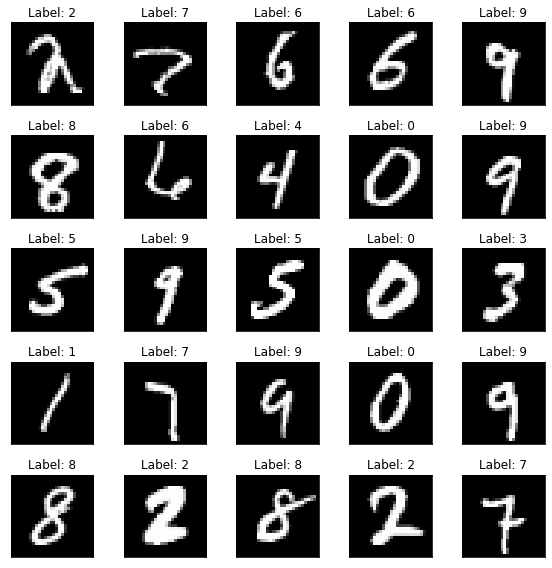

In [0]:

### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    #train_dataset contains tuples of images (a  vector of size 28x28) and correspondent labels
    img, label = random.choice(val_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()



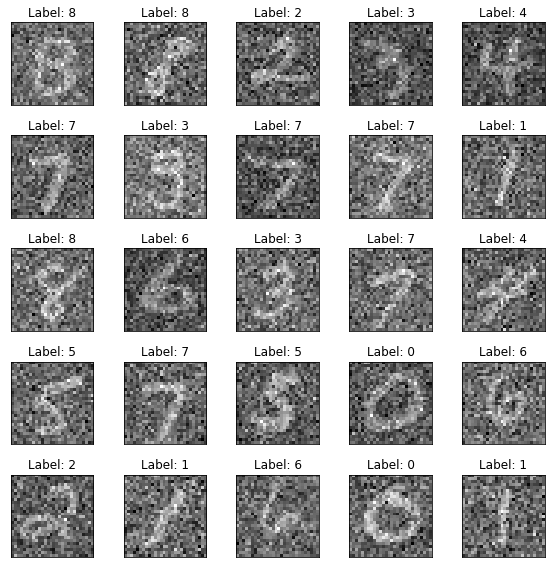

In [0]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    #train_dataset contains tuples of images (a  vector of size 28x28) and correspondent labels
    img, label = random.choice(noise_test_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

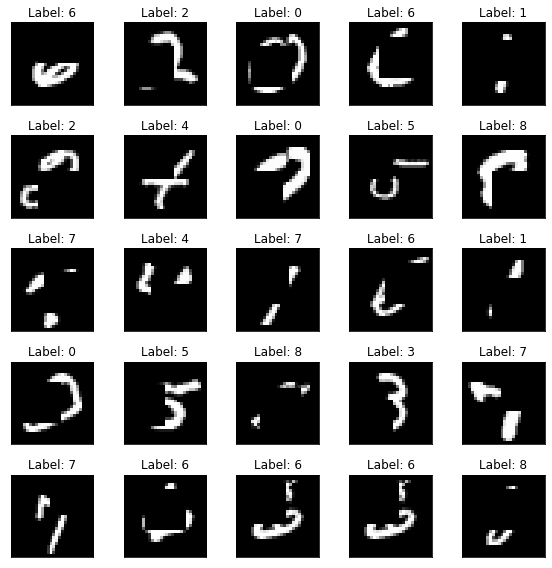

In [0]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    #train_dataset contains tuples of images (a  vector of size 28x28) and correspondent labels
    img, label = random.choice(occlusion_test_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

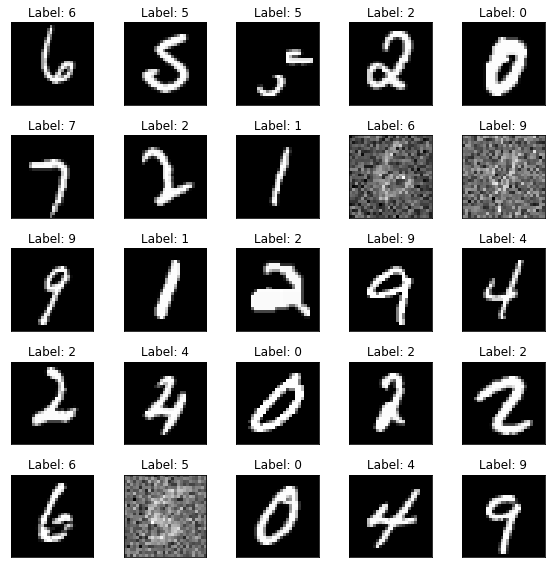

In [0]:

### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    #train_dataset contains tuples of images (a  vector of size 28x28) and correspondent labels
    img, label = random.choice(new_train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()



# NETWORK

In [0]:
class Autoencoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
            
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


In [0]:

### Define dataloader
new_train_dataloader = DataLoader(new_train_dataset, batch_size=512, shuffle=False)
new_val_dataloader = DataLoader(new_val_dataset, batch_size=512, shuffle=False)


train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [137]:

### Initialize the network
encoded_space_dim = 12
net = Autoencoder(encoded_space_dim=encoded_space_dim)


### Some examples
# Take an input image (remember to add the batch dimension)
img = test_dataset[0][0].unsqueeze(0)
print('Original image shape:', img.shape)
# Encode the image
img_enc = net.encode(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = net.decode(img_enc)
print('Decoded image shape:', dec_img.shape)



Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 12])
Decoded image shape: torch.Size([1, 1, 28, 28])


# PRETRAINING

In [138]:

#%% Prepare training



### Define a loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer
lr = 1e-3 # Learning rate
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

### If cuda is available set the device to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
net.to(device)


Autoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=12, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Con

In [0]:
#%% Network training


### Training function
def train_epoch(net, dataloader_in, dataloader_out, loss_fn, optimizer):
    # Training
    net.train()
    for sample_batch_in, sample_batch_out  in zip(dataloader_in, dataloader_out):
        # Extract data and move tensors to the selected device
        image_batch_in = sample_batch_in[0].to(device)
        image_batch_out = sample_batch_out[0].to(device)
        '''
        if (torch.all(torch.eq(sample_batch_in[1], sample_batch_out[1]))):
          print('ok')
        else:
          print('no')
        '''

              
              
        # Forward pass
        output = net(image_batch_in)
        loss = loss_fn(output, image_batch_out)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Print loss
        #print('\t partial train loss: %f' % (loss.data))


### Testing function
def test_epoch(net, dataloader_in, dataloader_out, loss_fn, optimizer):
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        conc_out = torch.Tensor().float()
        conc_label = torch.Tensor().float()
        for sample_batch_in, sample_batch_out  in zip(dataloader_in, dataloader_out):
            # Extract data and move tensors to the selected device
            image_batch_in = sample_batch_in[0].to(device)
            image_batch_out = sample_batch_out[0].to(device)
            # Forward pass
            out = net(image_batch_in)
            # Concatenate with previous outputs
            conc_out = torch.cat([conc_out, out.cpu()])
            conc_label = torch.cat([conc_label, image_batch_out.cpu()]) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data







# TRAINING

In [0]:
val_loss_log=[]
num_epochs = 1000

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training
    train_epoch(net, dataloader_in=new_train_dataloader, dataloader_out=train_dataloader, loss_fn=loss_fn, optimizer=optim) 
    ### Validation
    val_loss = test_epoch(net, dataloader_in=new_val_dataloader, dataloader_out=val_dataloader, loss_fn=loss_fn, optimizer=optim) 
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
    val_loss_log.append(val_loss)

    '''
    ### Plot progress
    img = val_dataset[0][0].unsqueeze(0).to(device)
    net.eval()
    with torch.no_grad():
        rec_img  = net(img)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    '''

    # Save network parameters
    torch.save(net.state_dict(), 'net_params.pth')
    #early stopping
    if (val_loss_log[-1]/min(val_loss_log)-1>0.01):
        break
    if (epoch>20) and (np.mean(val_loss_log[-10:-1])<val_loss_log[-1]):
        break

    # Save network parameters
    if (epoch%5==0):
      torch.save(net.state_dict(), 'net_params.pth')



EPOCH 1/1000


	 VALIDATION - EPOCH 1/1000 - loss: 0.071790


EPOCH 2/1000


	 VALIDATION - EPOCH 2/1000 - loss: 0.066752


EPOCH 3/1000


	 VALIDATION - EPOCH 3/1000 - loss: 0.064219


EPOCH 4/1000


	 VALIDATION - EPOCH 4/1000 - loss: 0.061033


EPOCH 5/1000


	 VALIDATION - EPOCH 5/1000 - loss: 0.057563


EPOCH 6/1000


	 VALIDATION - EPOCH 6/1000 - loss: 0.053584


EPOCH 7/1000


	 VALIDATION - EPOCH 7/1000 - loss: 0.048122


EPOCH 8/1000


	 VALIDATION - EPOCH 8/1000 - loss: 0.043199


EPOCH 9/1000


	 VALIDATION - EPOCH 9/1000 - loss: 0.039522


EPOCH 10/1000


	 VALIDATION - EPOCH 10/1000 - loss: 0.036290


EPOCH 11/1000


	 VALIDATION - EPOCH 11/1000 - loss: 0.034275


EPOCH 12/1000


	 VALIDATION - EPOCH 12/1000 - loss: 0.032877


EPOCH 13/1000


	 VALIDATION - EPOCH 13/1000 - loss: 0.030773


EPOCH 14/1000


	 VALIDATION - EPOCH 14/1000 - loss: 0.028665


EPOCH 15/1000


	 VALIDATION - EPOCH 15/1000 - loss: 0.027246


EPOCH 16/1000


	 VALIDATION - EPOCH 16/1000 - loss: 0.026

# LOG-ERROR


Text(0, 0.5, 'Error')

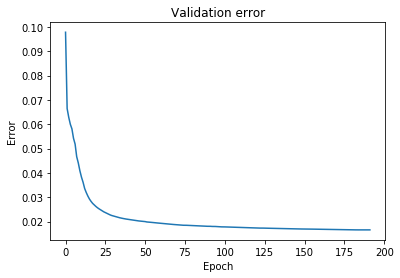

In [0]:
plt.plot(val_loss_log)
plt.title('Validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')

# ANALYSIS

In [140]:
encoded_space_dim = 10
net = Autoencoder(encoded_space_dim=encoded_space_dim)

# Load network parameters    
net.load_state_dict(torch.load('net_params.pth', map_location='cuda'))
net.to(device)

Autoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Con

In [141]:
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
noise_test_dataloader = DataLoader(noise_test_dataset, batch_size=512, shuffle=False)
occlusion_test_dataloader = DataLoader(occlusion_test_dataset, batch_size=512, shuffle=False)

test_loss = test_epoch(net, dataloader_in=test_dataloader, dataloader_out=test_dataloader, loss_fn=loss_fn, optimizer=optim)
print('TEST LOSS:', test_loss.item())

noise_test_loss = test_epoch(net, dataloader_in=noise_test_dataloader, dataloader_out=test_dataloader, loss_fn=loss_fn, optimizer=optim)
print('TEST LOSS NOISE DATA:', noise_test_loss.item())

occ_test_loss = test_epoch(net, dataloader_in=occlusion_test_dataloader, dataloader_out=test_dataloader, loss_fn=loss_fn, optimizer=optim)
print('TEST LOSS OCCLUDED DATA:', occ_test_loss.item())

TEST LOSS: 0.014136966317892075
TEST LOSS NOISE DATA: 0.02349070832133293
TEST LOSS OCCLUDED DATA: 0.030470050871372223


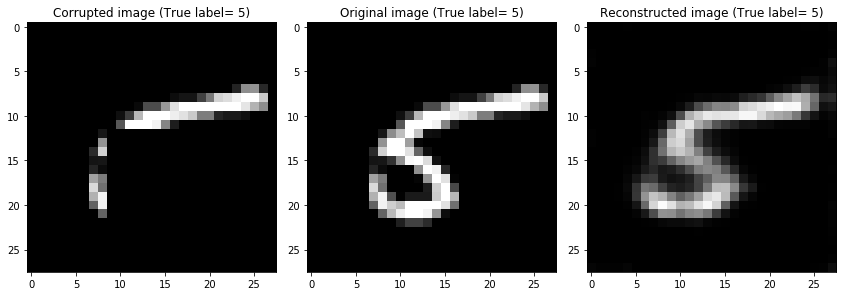

In [0]:
dato=331
### Plot progress
img = occlusion_test_dataset[dato][0].unsqueeze(0).to(device)
img_real = test_dataset[dato][0].unsqueeze(0).to(device)
net.eval()
with torch.no_grad():
    rec_img  = net(img)
fig, axs = plt.subplots(1, 3, figsize=(12,6))
axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Corrupted image (True label= %d)' % (occlusion_test_dataset[dato][1]))
axs[1].imshow(img_real.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Original image (True label= %d)' % (occlusion_test_dataset[dato][1]))
axs[2].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2].set_title('Reconstructed image (True label= %d)' % (occlusion_test_dataset[dato][1]))
plt.tight_layout()
plt.pause(0.1)


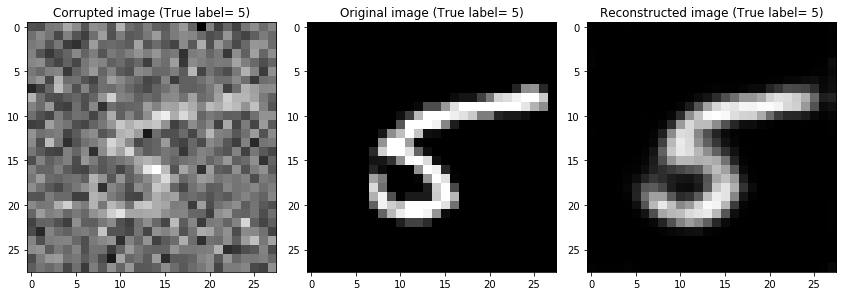

In [0]:
dato=331
### Plot progress
img = noise_test_dataset[dato][0].unsqueeze(0).to(device)
img_real = test_dataset[dato][0].unsqueeze(0).to(device)
net.eval()
with torch.no_grad():
    rec_img  = net(img)
fig, axs = plt.subplots(1, 3, figsize=(12,6))
axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Corrupted image (True label= %d)' % (noise_test_dataset[dato][1]))
axs[1].imshow(img_real.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Original image (True label= %d)' % (noise_test_dataset[dato][1]))
axs[2].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2].set_title('Reconstructed image (True label= %d)' % (noise_test_dataset[dato][1]))
plt.tight_layout()
plt.pause(0.1)


100%|██████████| 1000/1000 [00:01<00:00, 653.88it/s]


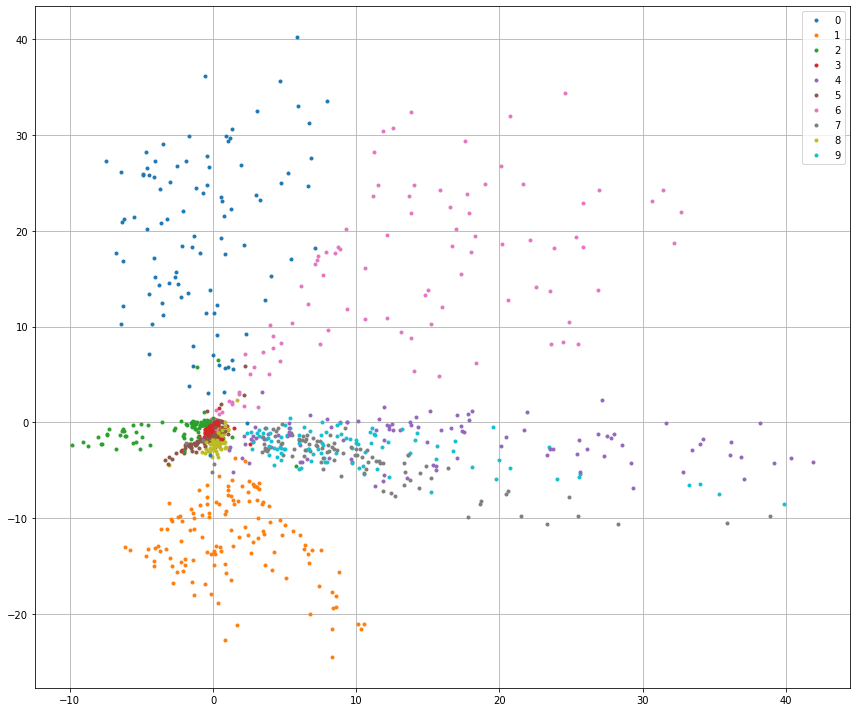

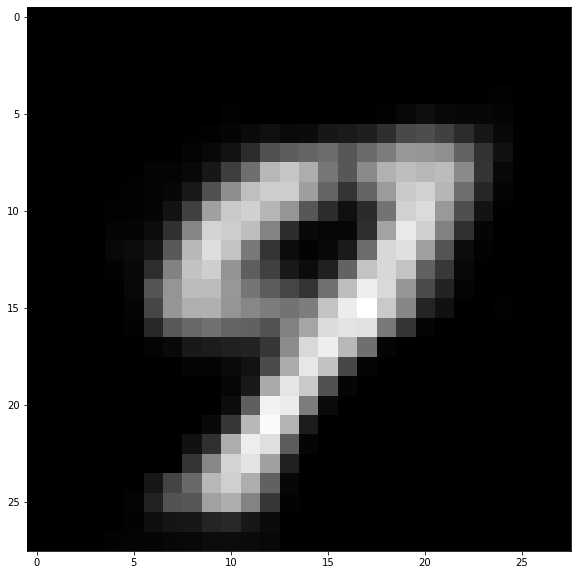

In [0]:

#%% Network analysis


# Load network parameters    
#net.load_state_dict(torch.load('net_params.pth', map_location='cpu'))

### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    net.eval()
    with torch.no_grad():
        encoded_img  = net.encode(img)
    # Append to list
    encoded_samples.append((encoded_img.flatten().cpu().numpy(), label))
    

### Visualize encoded space
color_map = {
        0: '#1f77b4',
        1: '#ff7f0e',
        2: '#2ca02c',
        3: '#d62728',
        4: '#9467bd',
        5: '#8c564b',
        6: '#e377c2',
        7: '#7f7f7f',
        8: '#bcbd22',
        9: '#17becf'
        }
    
# Plot just 1k points
encoded_samples_reduced = random.sample(encoded_samples, 1000)
plt.figure(figsize=(12,10))
for enc_sample, label in tqdm(encoded_samples_reduced):
    plt.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
plt.grid(True)
plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys())
plt.tight_layout()
plt.show()
        
if encoded_space_dim == 2:
    #%% Generate samples

    encoded_value = torch.tensor([20.0, -5.0]).float().unsqueeze(0)

    net.eval()
    with torch.no_grad():
        new_img  = net.decode(encoded_value.to(device))

    plt.figure(figsize=(12,10))
    plt.imshow(new_img.cpu().squeeze().numpy(), cmap='gist_gray')
    plt.show()
